# DCGANs

Introduction to **Deep Convolutional Generative Adversarial Networks** or DCGANs. 

This notebook is organized as follows:

1. **Background**
2. **Definition**
3. **Training DCGANs with Keras and TensorFlow**

---

## 1. Background

Brief definition of some concepts, such as convolution and Convolutional Neural Network (CNN).

### Convolution

Convolution is a mathematical operation which describes a rule of how to mix two functions or pieces of information.

* Features Map $I$
* Convolution kernel $K$
* Map of transformed features $S(i, j)$

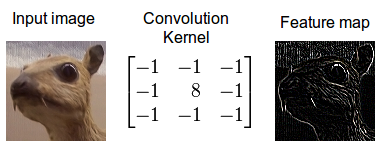

### Convolutional Neural Network (CNN)

Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers.

These convolutional layers have parameters that are learned so that these filters are adjusted automatically to extract the most useful information for the task at hand.

* Input is a multidimensional array of data,
* Kernel is a multidimensional array of parameters,
* These multidimensional arrays are tensors.

#### Layers CNN

* Convolution: extract features from imagem.
* Pooling: reduce dimension of entry.
* Dense / Fully connected: connect the layers.

## 2. Definition

The difference between the simple GAN and the DCGAN, is the generator of the simple GAN is a simple fully connected network. The generator of the DCGAN uses the transposed convolution (Fractionally-strided convolution or 
Deconvolution) technique to perform up-sampling of 2D image size.



## 3. Training DCGANs with Keras and TensorFlow

A DCGANs implementation using the transposed convolution technique and the [Keras](https://keras.io/) library.


### 1. Load data

#### Load libraries

In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten
from keras.optimizers import Adam
from keras import initializers
from keras.utils import plot_model
from keras import backend as K

Using TensorFlow backend.


#### Getting the data

In [3]:
# load dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#### Explore visual data

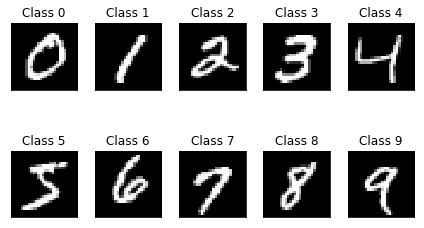

In [4]:
fig = plt.figure()
for i in range(10):
    plt.subplot(2, 5, i+1)
    x_y = X_train[y_train == i]
    plt.imshow(x_y[0], cmap='gray', interpolation='none')
    plt.title("Class %d" % (i))
    plt.xticks([])
    plt.yticks([])
    
plt.tight_layout()

#### Reshaping and normalizing the inputs

In [5]:
print('X_train.shape', X_train.shape)

if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
    X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
    input_shape = (1, 28, 28)
else:
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
    X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
    input_shape = (28, 28, 1)

# the generator is using tanh activation, for which we need to preprocess 
# the image data into the range between -1 and 1.
X_train = X_train.reshape(-1, 28, 28, 1) # 28,28,1
X_train = np.float64(X_train)
X_train = (X_train / 255 - 0.5) * 2
X_train = np.clip(X_train, -1, 1)

print('X_train reshape:', X_train.shape)

X_train.shape (60000, 28, 28)
X_train reshape: (60000, 28, 28, 1)


### 2. Define model

#### Generator

Our generator using the **inverse of convolution**, called transposed convolution. 

In between layers, BatchNormalization stabilizes learning. 

The activation function after each layer is a LeakyReLU. 

The output of the tanh at the last layer produces the fake image. 

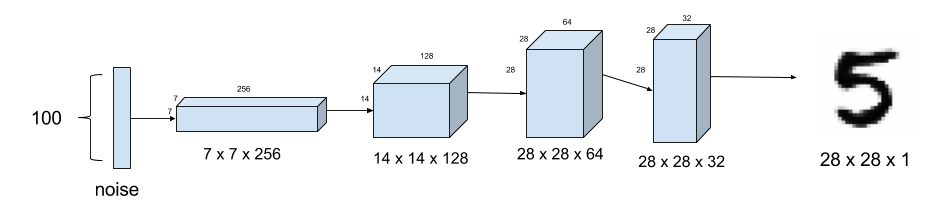

In [6]:
# latent space dimension
latent_dim = 100

# imagem dimension 28x28
img_dim = 784

init = initializers.RandomNormal(stddev=0.02)

# Generator network
generator = Sequential()

# FC: 4x4x256
generator.add(Dense(256*4*4, input_shape=(latent_dim,),
                    kernel_initializer=init))
generator.add(Reshape((4, 4, 256)))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 1: 8x8x128
generator.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 16x16x32
generator.add(Conv2DTranspose(32, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 2: 16x16x32
generator.add(Conv2DTranspose(16, kernel_size=5, strides=2, padding='same'))
generator.add(BatchNormalization())
generator.add(LeakyReLU(0.2))

# Conv 3: 28x28x1
generator.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same',
                              activation='tanh'))

#### Generator model visualization

In [7]:
# # plot a generator Keras model
# plot_model(generator, to_file='img/generator_model.png',
#            show_shapes=True, show_layer_names=True)

# prints a summary representation of your model
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 4096)              413696    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 128)         819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
__________

#### Discriminator

Our discriminator is a **convolutional neural network** that takes a 28x28 image with 1 channel. The values in the image is expected to be between -1 and 1.

It takes a digit image and classifies whether an image is real (1) or not (0).

The last activation is sigmoid to tell us the probability of whether the input image is real or not.

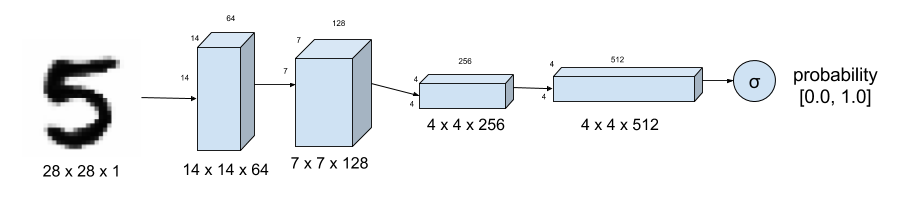

In [8]:
# Discriminator network
discriminator = Sequential()
# Conv 1: 16x16x32
discriminator.add(Conv2D(32, kernel_size=5, strides=2, padding='same',
                         input_shape=(28, 28, 1), kernel_initializer=init))
# discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 2:
discriminator.add(Conv2D(16, kernel_size=5, strides=2, padding='same'))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))

# Conv 3: 
# discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
# discriminator.add(LeakyReLU(0.2))

# FC
discriminator.add(Flatten())
discriminator.add(Dense(784))
discriminator.add(BatchNormalization())
discriminator.add(LeakyReLU(0.2))


# Output
discriminator.add(Dense(1, activation='sigmoid'))

#### Discriminator model visualization

In [9]:
# # plot a generator Keras model
# plot_model(discriminator, to_file='img/discriminator_model.png',
#            show_shapes=True, show_layer_names=True)

# prints a summary representation of your model
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          12816     
_________________________________________________________________
batch_normalization_5 (Batch (None, 7, 7, 16)          64        
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 784)               615440    
__________

### 3. Compile model

#### Compile discriminator

In [10]:
# Optimizer
opt = Adam(lr=0.0002, beta_1=0.5)

discriminator.compile(opt, loss='binary_crossentropy',
                      metrics=['binary_accuracy'])

#### Combined network

In [11]:
# d_g = discriminador(generador(z))
discriminator.trainable = False

z = Input(shape=(latent_dim,))
img = generator(z)
decision = discriminator(img)
d_g = Model(inputs=z, outputs=decision)

d_g.compile(opt, loss='binary_crossentropy',
            metrics=['binary_accuracy'])

### 4. Fit model

We train the discriminator and the generator in turn in a loop as follows:

1. Set the discriminator trainable
2. Train the discriminator with the real digit images and the images generated by the generator to classify the real and fake images.
3. Set the discriminator non-trainable
4. Train the generator as part of the GAN. We feed latent samples into the GAN and let the generator to produce digit images and use the discriminator to classify the image.

In [12]:
epochs = 100
batch_size = 64

real = np.ones(shape=(batch_size, 1))
fake = np.zeros(shape=(batch_size, 1))

d_loss = []
g_loss = []

for e in range(epochs):
    for i in range(len(X_train) // batch_size):
    # Train Discriminator weights
        # Real samples
        X_batch = X_train[i*batch_size:(i+1)*batch_size]
        d_loss_real = discriminator.train_on_batch(x=X_batch, y=real)
        
        # Fake Samples
        # z = np.random.uniform(size=(batch_size, latent_dim))
        z = np.random.normal(loc=0, scale=1, size=(batch_size, latent_dim))
        X_fake = generator.predict(z)
        d_loss_fake = discriminator.train_on_batch(x=X_fake, y=fake)
         
        # Discriminator loss
        d_loss_batch = 0.5 * (d_loss_real[0] + d_loss_fake[0])
        
    # Train Generator weights
        g_loss_batch = d_g.train_on_batch(x=z, y=real)
        
        print(
            'epoch = %d/%d, batch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, i, len(X_train) // batch_size, d_loss_batch, g_loss_batch[0]),
            100*' ',
            end='\r'
        )
    
    d_loss.append(d_loss_batch)
    g_loss.append(g_loss_batch[0])
    print('epoch = %d/%d, d_loss=%.3f, g_loss=%.3f' % (e + 1, epochs, d_loss[-1], g_loss[-1]), 100*' ')

    if e % 10 == 0:
        samples = 10
        x_fake = generator.predict(np.random.uniform(size=(samples, latent_dim)))

        for k in range(samples):
            plt.subplot(2, 5, k+1)
            plt.imshow(x_fake[k].reshape(28, 28), cmap='gray')
            plt.xticks([])
            plt.yticks([])

        plt.tight_layout()
        plt.show()

/opt/anaconda/lib/python3.6/site-packages/keras/engine/training.py:975: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


ValueError: Error when checking input: expected conv2d_1_input to have shape (28, 28, 1) but got array with shape (64, 64, 1)

### 5. Evaluate model

In [ ]:
# plotting the metrics
plt.plot(d_loss)
plt.plot(g_loss)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Discriminator', 'Generator'], loc='center right')
plt.show()

## References

* [Generative Adversarial Networks or GANs](https://arxiv.org/abs/1406.2661)
* [How to Train a GAN? Tips and tricks to make GANs work](https://github.com/soumith/ganhacks)
* [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)
* [Convolution](https://devblogs.nvidia.com/deep-learning-nutshell-core-concepts/)